In [1]:
#%%writefile Cointegration.py
#https://medium.com/@bart.chr/pairs-trading-for-algorithmic-trading-breakdown-d8b709f59372
#https://github.com/aconstandinou/mean-reversion

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import statistics

import matplotlib.pyplot as plt

# Functions/Methods

In [22]:
"""
Augmented Dickey–Fuller (ADF) unit root test; p-value < .05
"""
class DickeyFuller(object):
    def __init__(self, significance=.05):
        self.significance_level = significance
        self.p_value = None
        self.perc_stat = None
        self.is_stationary = None
        
    def check(self, time_series):
        model = ts.adfuller(time_series, 1)
        self.p_value = model[1]
        self.perc_stat = model[0]
        
        self.is_stationary = False
        if (self.p_value < self.significance_level):
            self.is_stationary = True
        return self.is_stationary;

"""
Half Life test from the Ornstein-Uhlenbeck process 
"""
class HalfLife(object):
    def __init__(self):
        self.half_life = None

    def check(self, time_series):
        lag = np.roll(time_series, 1)
        lag[0] = 0
        ret = time_series - lag
        ret[0] = 0

        # adds intercept terms to X variable for regression
        lag2 = sm.add_constant(lag)
        res = sm.OLS(ret, lag2).fit()
        self.half_life = int(round(-np.log(2) / res.params[1],0))

        if self.half_life <= 0:
            self.half_life = 1
        return self.half_life

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
"""
class HurstExponent():
    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        #https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
        self.lag_max = 20#era 100
        self.h_value = None
    
    def check(self, time_series):
        lags = range(2, self.lag_max)

        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        self.h_value = poly[0]*2.0 
        return self.h_value

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

# beta/coeficiente angular
def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

# check cointegrated pairs from dataframe
def find_cointegrated_pairs(data, num_pairs=0):
    adf = DickeyFuller()
    rows = []
    isBreak = False

    for col_depen in data.columns:
        for col_indepen in data.columns:
            if (col_depen == col_indepen):
                continue
            
            model = model_ols(data[col_depen], data[col_indepen])
            adf.check(model.resid)
            beta = model.params[1]
            if (adf.is_stationary):
                rows.append([col_depen,col_indepen,adf.p_value, adf.perc_stat, beta])
                    
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break

    df_pairs = pd.DataFrame(rows, columns=['Dependente', 'Independente', 'pValue', 'ADFStatistic', 'Beta'])
    return df_pairs

def cointegration(y, x, period = 0):
    adf = DickeyFuller()
    if (period > 0):
        pos = data.shape[0]-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    else:
        period = len(y)
        
    model = model_ols(y, x)
    adf.check(model.resid)
    return [adf.p_value, adf.is_stationary, model.params[1], period]

def apply_halflife(data, pairs):
    pairs['HalfLife'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        value = check_halflife(y, x)
        pairs['HalfLife'].iloc[i]=value
    return pairs

def check_halflife(y, x):
    halflile = HalfLife()
    model = model_ols(y, x)
    return halflile.check(model.resid)

def apply_hurst(data, pairs):
    pairs['Hurst'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        value = check_hurst(y, x)
        pairs['Hurst'].iloc[i]= value
    return pairs

def check_hurst(y, x):
    hurst = HurstExponent()
    model = model_ols(y, x)
    return hurst.check(model.resid.as_matrix())

# 0.9 para mais ou para menos indica uma correlação muito forte.
# 0.7 a 0.9 positivo ou negativo indica uma correlação forte.percorre
# 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# 0 a 0.3 positivo ou negativo indica uma correlação desprezível.'''
def corr_pearson(y, x):
    y_avg, x_avg = np.average(y), np.average(x)
    y_stdev, x_stdev = np.std(y), np.std(x)
    n = len(y)
    denominator = y_stdev * x_stdev * n
    numerator = np.sum(np.multiply(y-y_avg, x-x_avg))
    p_coef = numerator/denominator
    return p_coef

def apply_corr(data, pairs):
    pairs['Corr'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        corr = corr_pearson(y, x)
        pairs['Corr'].iloc[i] = corr
    return pairs

def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'SL'
        zcurrent = zscore_up
    else:
        desc = 'LS'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

def apply_signal(data, pairs):
    pairs['Signal'] = ''
    pairs['SignalPerc'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]

        sig = signal(y, x)
        pairs['Signal'].iloc[i] = sig[0]
        pairs['SignalPerc'].iloc[i] = sig[2]
    return pairs

def check_periods(data, y_symbol, x_symbol, period):    
    if (type(period) is int):
        return check_oneperiod(data, y_symbol, x_symbol, period)
    if (type(period) is list):
        rows=[]
        for p in period:
            res = check_oneperiod(data, y_symbol, x_symbol, p)
            rows.append([res[0], res[1]])
        return rows

def check_oneperiod(data, y_symbol, x_symbol, period):
    y = data[y_symbol]
    x = data[x_symbol]
    
    if(period > 0):
        pos = data.shape[0]-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    
    adf = DickeyFuller()
    model = model_ols(y, x)
    adf.check(model.resid)
    beta = model.params[1]

    return [adf.p_value, adf.is_stationary];

def show(data, y_symbol, x_symbol):
    y = data[y_symbol]
    x = data[x_symbol]
    
    model= model_ols(y, x)
    std = statistics.stdev(model.resid)
    entry_threshold = 2 # entrada em 2 desvio padrão

    #plt.figure(figsize=(15,6))
    plt.figure(figsize=(10,5))
    plt.plot(model.resid)
    plt.ylabel('Residual')
    plt.title(y_symbol + ' / ' + x_symbol)

    plt.axhline(0, color='black',label='mean',linestyle='--') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
    plt.axhline(-entry_threshold*std, color='green', linestyle='--')

    plt.legend()
    plt.show()

## Read CSV

In [3]:
#df = pd.read_csv('datasets/data.csv')
df = pd.read_csv('datasets/data_cart.csv')
data = df[df.columns.difference(['Data'])]
data.shape

(352, 72)

In [11]:
pairs = find_cointegrated_pairs(data, 0)
pairs.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Dependente,Independente,pValue,ADFStatistic,Beta
0,ABEV3,BBAS3,0.030955,-3.044348,0.264113
1,ABEV3,CMIG4,0.041807,-2.931485,1.101929
2,ABEV3,CVCB3,0.035537,-2.993168,0.130617


In [12]:
pairs = apply_halflife(data, pairs)
pairs.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife
0,ABEV3,BBAS3,0.030955,-3.044348,0.264113,14
1,ABEV3,CMIG4,0.041807,-2.931485,1.101929,15
2,ABEV3,CVCB3,0.035537,-2.993168,0.130617,17


In [13]:
pairs = apply_hurst(data, pairs)
pairs.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst
0,ABEV3,BBAS3,0.030955,-3.044348,0.264113,14,0.398124
1,ABEV3,CMIG4,0.041807,-2.931485,1.101929,15,0.467016
2,ABEV3,CVCB3,0.035537,-2.993168,0.130617,17,0.374882


In [14]:
pairs = apply_corr(data, pairs)
pairs.head(3)

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr
0,ABEV3,BBAS3,0.030955,-3.044348,0.264113,14,0.398124,0.873624
1,ABEV3,CMIG4,0.041807,-2.931485,1.101929,15,0.467016,0.867061
2,ABEV3,CVCB3,0.035537,-2.993168,0.130617,17,0.374882,0.850342


In [15]:
apply_signal(data, pairs)
pairs.head(3)

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalPerc
0,ABEV3,BBAS3,0.030955,-3.044348,0.264113,14,0.398124,0.873624,LS,0.247693
1,ABEV3,CMIG4,0.041807,-2.931485,1.101929,15,0.467016,0.867061,LS,0.641010
2,ABEV3,CVCB3,0.035537,-2.993168,0.130617,17,0.374882,0.850342,LS,0.296603


In [16]:
pairs.to_csv('datasets/cointegrated_pairs.csv')
print('Criado com sucesso!!!')

Criado com sucesso!!!


# Analysis

In [18]:
pairs = pd.read_csv('datasets/cointegrated_pairs.csv', index_col=0)
pairs.shape

(612, 10)

In [21]:
df_hurst = pairs.loc[(pairs['Hurst'] > 0) & (pairs['Hurst'] < 0.4)]
df_hurst

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalPerc
0,ABEV3,BBAS3,0.030955,-3.044348,0.264113,14,0.398124,0.873624,LS,0.247693
2,ABEV3,CVCB3,0.035537,-2.993168,0.130617,17,0.374882,0.850342,LS,0.296603
6,ABEV3,HGTX3,0.000170,-4.535083,0.345462,7,0.316811,0.949225,SL,0.439028
7,ABEV3,ITSA4,0.017330,-3.248759,1.357628,12,0.396552,0.894738,LS,0.223494
8,ABEV3,ITUB4,0.003567,-3.741434,0.460423,10,0.379978,0.904904,LS,0.197496
...,...,...,...,...,...,...,...,...,...,...
607,VIVT4,SULA11,0.000605,-4.221660,0.346183,8,0.269676,0.874957,LS,1.147554
608,VIVT4,TAEE11,0.004516,-3.672547,1.907475,8,0.305117,0.878264,LS,1.535355
609,VIVT4,TOTS3,0.000057,-4.791174,0.233571,6,0.249204,0.841956,SL,0.718218
610,VVAR3,CSAN3,0.006733,-3.552685,0.261958,10,0.378098,0.945109,SL,0.843615


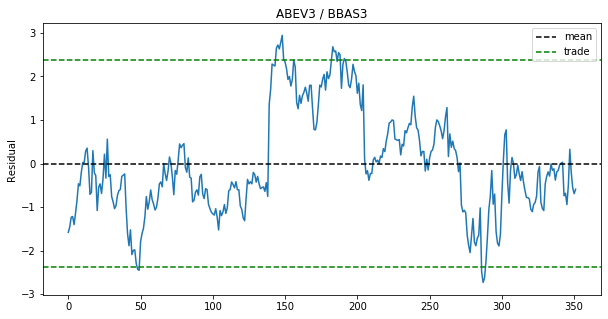

In [22]:
show(data, 'ABEV3', 'BBAS3')

In [23]:
corr = df_hurst.loc[(df_hurst['Corr'] >= 0.95)]
corr

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalPerc
24,BBAS3,EMBR3,0.002936,-3.797217,1.945949,8,0.374262,0.954310,SL,0.890184
25,BBAS3,ITUB4,0.023133,-3.149003,1.600146,13,0.339675,0.950760,LS,0.089278
92,BRML3,IGTA3,0.010225,-3.422193,0.362858,8,0.281163,0.975221,LS,0.378588
93,BRML3,LREN3,0.002091,-3.892497,0.388807,6,0.223352,0.958791,LS,1.141917
94,BRML3,MULT3,0.000181,-4.519791,0.619347,6,0.133724,0.978512,LS,1.044678
216,ELET3,ELET6,0.003770,-3.725354,1.090192,8,0.340674,0.988335,SL,0.391139
227,ELET6,ELET3,0.001173,-4.049311,0.895994,8,0.350675,0.988335,LS,0.458132
234,EMBR3,BBAS3,0.005273,-3.626576,0.468001,8,0.367744,0.954310,LS,1.184465
236,EMBR3,SANB11,0.007129,-3.535145,0.510154,10,0.374283,0.953811,LS,0.785686
292,GGBR4,GOAU4,0.007282,-3.528608,2.033406,6,0.239741,0.993288,SL,0.854460


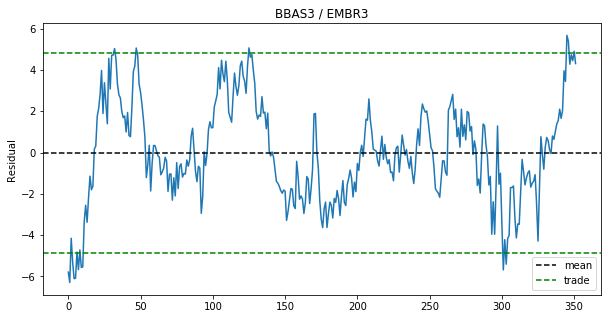

In [29]:
show(data, 'BBAS3', 'EMBR3')

In [31]:
check_periods(data, 'BBAS3', 'EMBR3', [100, 120, 140, 160, 180, 200, 220, 240, 250])

[[0.20025655538711923, False],
 [0.12714962483159875, False],
 [0.06643860240996743, False],
 [0.026986540420061052, True],
 [0.030526348457823427, True],
 [0.009832500074639082, True],
 [0.0063363044273144434, True],
 [0.017319707696923908, True],
 [0.01647677192066213, True]]

In [24]:
cointegration(data['BBAS3'], data['EMBR3'], 0)

[0.0029359133272207553, True, 1.9459486001274704, 352]